# Kloppy

In [1]:
%load_ext autoreload
%autoreload 2

from kloppy import sportec
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mplsoccer import Pitch
import numpy as np
import pandas as pd
import polars as pl
from tqdm import tqdm
pd.set_option('display.max_columns', None)  # 모든 열 출력
from unravel.soccer import KloppyPolarsDataset

import os 
import pickle
import sys

sys.path.append(os.path.abspath(".."))
from pressing_intensity import CustomPressingIntensity
from visualization import plot_single_frame_positions, plot_window_frame_positions
from config import TEAMNAME2ID, TEAMID2NAME

coordinates = "secondspectrum"

2025-06-07 18:19:23.142204: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-07 18:19:23.144558: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-07 18:19:23.172222: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-07 18:19:23.172255: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-07 18:19:23.172275: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
def _normalize_coordinate_direction(df, home_team_id):
    """
    Normalizes the coordinate system within the DataFrame to ensure the home team
    always attacks in a consistent direction (e.g., left-to-right).
    Modifies the DataFrame based on period and initial home team orientation.

    Args:
        df (pd.DataFrame): The tracking DataFrame to process. Must contain
                            'period_id', 'frame_id', 'x', 'y', 'team_id' columns.
                            Will also flip 'vx', 'vy', 'ax', 'ay' if they exist.
        home_team_id (str): The team ID of the home team.

    Returns:
        pd.DataFrame: A DataFrame with normalized coordinate directions.
                        (Does not modify the input df directly, works on a copy).
    """
    cols_to_flip = ['x', 'y', 'vx', 'vy', 'ax', 'ay']
    df_normalized = df.copy()
    # --- 1. Unify direction for the second half ---
    # Create a mask for the second half (period_id == 2)
    second_half_mask = df_normalized['period_id'] == 2

    # List of kinematic columns (vectors) to flip along with coordinates
    

    # Flip the sign of coordinates and related vectors for second-half data
    for col in cols_to_flip:
        if col in df_normalized.columns:
            # Only attempt sign flip if the column is not of object type
            if df_normalized[col].dtype != 'object':
                df_normalized.loc[second_half_mask, col] = -df_normalized.loc[second_half_mask, col]
            else:
                # Handle object type columns (e.g., do nothing)
                pass
    
    # --- 2. Check home team attack direction and flip all if necessary ---
    # Find the first frame ID in the first period (period_id == 1)
    first_period_frames = df_normalized[df_normalized['period_id'] == 1]['frame_id']
    if not first_period_frames.empty:
        first_frame_idx = first_period_frames.unique()[0]
        first_frame_df = df_normalized[(df_normalized['period_id'] == 1) & (df_normalized['frame_id'] == first_frame_idx) & (df_normalized['team_id'] != 'ball')].copy()

        if not first_frame_df.empty and not first_frame_df['x'].isna().all():
            # Find the team ID of the entity with the minimum 'x' value (usually leftmost player/ball)
            try:
                min_x_team_id = first_frame_df.loc[first_frame_df['x'].idxmin(), 'team_id']

                # If the leftmost entity is not the home team, assume home team is attacking right-to-left
                # In this case, flip all coordinates and vectors for the entire match.
                if min_x_team_id != home_team_id:
                    for col in cols_to_flip:
                        if col in df_normalized.columns:
                            if df_normalized[col].dtype != 'object':
                                # Use .loc to modify the DataFrame slice directly
                                df_normalized.loc[:, col] = -df_normalized.loc[:, col]
                            else:
                                pass
            except ValueError:
                # Handle cases where idxmin() fails (e.g., all 'x' values are NaN)
                print(f"Warning: Could not determine minimum 'x' value for frame {first_frame_idx}. Skipping orientation check.")
        else:
            print(f"Warning: No valid data found for the first frame ({first_frame_idx}) of period 1. Skipping main orientation check.")
    else:
        print("Warning: No data found for period 1. Skipping main orientation check.")
    return df_normalized


In [38]:
data_path = "/data/MHL/bepro/processed/"
results = []
if os.path.exists(data_path):
    match_id_lst = os.listdir(data_path)
    total_dict = {match_id : {} for match_id in match_id_lst}
    for match_id in match_id_lst:
        if match_id != "126315": continue
        print(f"Load {match_id}")
        with open(f"{data_path}/{match_id}/{match_id}_processed_dict.pkl", "rb") as f:
            match_dict = pickle.load(f)
        tracking_df = match_dict['tracking_df']
        teams_dict = match_dict['teams']
        with open(f"{data_path}/{match_id}/{match_id}_presing_intensity.pkl", "rb") as f:
            pressing_df = pickle.load(f)

        total_df = pd.merge(tracking_df, pressing_df, on=['game_id', 'period_id', 'timestamp', 'frame_id'], how='left')
        total_df = _normalize_coordinate_direction(total_df, teams_dict['Home']['pID'].iloc[0])
        total_dict[match_id] = {}
        total_dict[match_id]['tracking_df'] = total_df
        total_dict[match_id]['Home'] = match_dict['teams']['Home']
        total_dict[match_id]['Away'] = match_dict['teams']['Away']

else:
    match_id_lst = [x.split("-")[-1] for x in os.listdir("/data/MHL/dfl-spoho/raw/")]
    totals = {x : {} for x in match_id_lst}
    for match_id in match_id_lst:
        if match_id != 'J03WQQ': continue
        with open(f"/data/MHL/pressing-intensity/{match_id}.pkl", "rb") as f:
            output = pickle.load(f)
        kloppy_dataset = sportec.load_open_tracking_data(
        match_id=match_id, coordinates=coordinates
        )
        home_team, away_team = kloppy_dataset.metadata.teams
        
        dataset = KloppyPolarsDataset(kloppy_dataset=kloppy_dataset, orient_ball_owning=False)
        model = CustomPressingIntensity(dataset=dataset)
        total_df = model.dataset.to_pandas()
        # if np.array_equal(np.unique(total_df['frame_id'].value_counts().values), np.array([23])):
        #     continue
        total_df = pd.merge(total_df, output, on=['game_id', 'period_id', 'timestamp', 'frame_id'], how='left')
        mask = total_df['period_id'] == 2
        total_df.loc[mask, 'x'] = -total_df.loc[mask, 'x']
        total_df.loc[mask, 'y'] = -total_df.loc[mask, 'y']

        totals[match_id]['df'] = total_df
        totals[match_id]['home'] = home_team
        totals[match_id]['away'] = away_team
        break

        # # Check when ball carrier is pressed (Pressing Intensity higher than 0.7)
        # pressed_dict = dict()
        # ball_carrier_df = total_df[total_df['is_ball_carrier']==True]
        # ball_carrier_df.sort_values('frame_id', inplace=True)
        
        # for idx, row in ball_carrier_df.iterrows():
        #     if len(np.where(row['columns'] == row['id'])[0]) != 0:
        #         id_loc = np.where(row['columns'] == row['id'])[0]
        #         pressing_values = [x[id_loc] for x in row['probability_to_intercept']]
        #     elif len(np.where(row['rows'] == row['id'])[0]) != 0:
        #         id_loc = np.where(row['rows'] == row['id'])[0]
        #         pressing_values = row['probability_to_intercept'][id_loc].tolist()[0].tolist()
        #     if max(pressing_values) > 0.7:
        #         pressed_dict[idx] = max(pressing_values)

        # pressed_df = ball_carrier_df.loc[list(pressed_dict.keys())]
        # pressed_df['max_pressing_values'] = list(pressed_dict.values())
        # pressed_df['is_consecutive'] = pressed_df['frame_id'].diff() < 50
        # results.append(pressed_df)

        # break

Load 126315


In [59]:
feature_cols = ['x', 'y', 'vx', 'vy', 'v', 'ax', 'ay', 'a']

for match_id in match_id_lst:
    total_df = total_dict[match_id]['tracking_df']
    if total_df[feature_cols].isna().any().any():
        print(match_id)

In [ ]:
def get_event_name(x):
    event_name_lst = []
    for val in x:
        if "event_name" in val:
            event_name_lst.append(val['event_name'])
        elif "name" in val:
            event_name_lst.append(val['name'])
    return event_name_lst

event_name_unique = []

for match_id in match_id_lst:
    with open(f"{data_path}/{match_id}/{match_id}_processed_dict.pkl", "rb") as f:
        match_dict = pickle.load(f)
    event_df = match_dict['event_df']    
    event_df['events_name'] = event_df['events'].apply(get_event_name)
    for idx, row in event_df.iterrows():
    # event_name_unique += row['events_name']
        event_name_unique.append(row['events_name'][0])
set(event_name_unique)

In [39]:
# match_id = match_id_lst[0]
# match_id = pressed_error_lst[0]
match_id = "126315"

total_df = total_dict[match_id]['tracking_df']
home_team = total_dict[match_id]['Home']
away_team = total_dict[match_id]['Away']

with open(f"{data_path}/{match_id}/{match_id}_processed_dict.pkl", "rb") as f:
    match_dict = pickle.load(f)

event_df = match_dict['event_df']    
meta_data = match_dict['meta_data']
teamname2id = {meta_data['home_team']['team_name'] : meta_data['home_team']['team_id'],
               meta_data['away_team']['team_name'] : meta_data['away_team']['team_id']
               }
teamid2name = {meta_data['home_team']['team_id'] : meta_data['home_team']['team_name'],
               meta_data['away_team']['team_id'] : meta_data['away_team']['team_name']
               }

In [40]:
total_df.columns

Index(['game_id', 'period_id', 'timestamp', 'frame_id', 'ball_state',
       'ori_ball_owning_team_id', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'v', 'ax',
       'ay', 'az', 'a', 'id', 'team_id', 'position_name',
       'ball_owning_team_id', 'is_ball_carrier', 'time_to_intercept',
       'probability_to_intercept', 'columns', 'rows'],
      dtype='object')

In [41]:
total_df.head()

,game_id,period_id,timestamp,frame_id,ball_state,ori_ball_owning_team_id,x,y,z,vx,vy,vz,v,ax,ay,az,a,id,team_id,position_name,ball_owning_team_id,is_ball_carrier,time_to_intercept,probability_to_intercept,columns,rows
0,126315,1,0 days 00:00:02.166000,65,dead,None,-10.6648,15.7343,0.0,-0.007321,-0.000433,0.0,0.007334,-0.078709,-0.183655,0.0,0.199810,145701,4648,LB,4648,False,"[[4.218746107687284, 6.4277113296931585, 4.303...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[145701, 250099, 250102, 360389, 500133, 50013...","[356609, 356615, 356616, 356618, 356624, 35662..."
1,126315,1,0 days 00:00:02.166000,65,dead,None,-49.4965,1.8147,0.0,-0.000000,0.013725,0.0,0.013725,-0.000000,-0.196773,0.0,0.196773,250099,4648,GK,4648,False,"[[4.218746107687284, 6.4277113296931585, 4.303...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[145701, 250099, 250102, 360389, 500133, 50013...","[356609, 356615, 356616, 356618, 356624, 35662..."
2,126315,1,0 days 00:00:02.166000,65,dead,None,-0.3045,15.3609,0.0,0.724051,0.695926,0.0,1.004272,1.849665,0.970746,0.0,2.088926,250102,4648,CF,4648,False,"[[4.218746107687284, 6.4277113296931585, 4.303...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[145701, 250099, 250102, 360389, 500133, 50013...","[356609, 356615, 356616, 356618, 356624, 35662..."
3,126315,1,0 days 00:00:02.166000,65,dead,None,16.2257,-16.2615,0.0,0.465292,-0.083843,0.0,0.472785,-0.262364,-0.642792,0.0,0.694274,356609,2353,LB,4648,False,"[[4.218746107687284, 6.4277113296931585, 4.303...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[145701, 250099, 250102, 360389, 500133, 50013...","[356609, 356615, 356616, 356618, 356624, 35662..."
4,126315,1,0 days 00:00:02.166000,65,dead,None,0.0186,-21.5149,0.0,-0.946104,0.273160,0.0,0.984748,-0.170537,6.991998,0.0,6.000000,356615,2353,LW,4648,False,"[[4.218746107687284, 6.4277113296931585, 4.303...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[145701, 250099, 250102, 360389, 500133, 50013...","[356609, 356615, 356616, 356618, 356624, 35662..."


In [42]:
feature_cols = ['x', 'y', 'vx', 'vy', 'v', 'ax', 'ay', 'a']

for col in feature_cols:
    print(f"{col} : {total_df[col].min()} ~ {total_df[col].max()}")

x : -57.75 ~ 57.75
y : -39.6492 ~ 37.0564
vx : -78.57673796791448 ~ 226.14851455733813
vy : -171.85295229575678 ~ 211.0878980523989
v : 0.0 ~ 28.0
ax : -6713.621059075605 ~ 6642.883379247017
ay : -6396.541169268442 ~ 6396.541169268442
a : 0.0 ~ 13.5


In [43]:
event_df.columns

Index(['period_type', 'period_name', 'period_order', 'period_duration',
       'period_start_time', 'event_time', 'team_name', 'player_shirt_number',
       'player_name', 'events', 'x', 'y', 'to_x', 'to_y', 'attack_direction'],
      dtype='object')

In [44]:
event_df.head()

,period_type,period_name,period_order,period_duration,period_start_time,event_time,team_name,player_shirt_number,player_name,events,x,y,to_x,to_y,attack_direction
0,Half,1st Half,0,2700000,0,2167,Gwangju FC,24,Kang Hyun Lee,"[{'event_name': 'Passes', 'property': {'Outcom...",0.500800,0.527100,0.657600,0.689500,LEFT
1,Half,1st Half,0,2700000,0,3000,Gimcheon Sangmu,18,Kanghyun Yu,"[{'name': 'VHIR', 'property': {'duration': 200...",0.533551,0.654105,0.637543,0.683009,RIGHT
2,Half,1st Half,0,2700000,0,3000,Gwangju FC,20,Kunhee Lee,"[{'name': 'VHIR', 'property': {'duration': 250...",0.482749,0.274083,0.354669,0.275258,LEFT
3,Half,1st Half,0,2700000,0,3500,Gwangju FC,11,Gabriel,"[{'name': 'VHIR', 'property': {'duration': 150...",0.467462,0.754444,0.398143,0.716478,LEFT
4,Half,1st Half,0,2700000,0,3967,Gwangju FC,6,Youngkyu Ahn,"[{'event_name': 'Passes Received', 'property':...",0.657600,0.689500,NaN,NaN,LEFT


In [45]:
event_df[event_df['events'].apply(lambda x: len(x)) != 1]['events'].iloc[0]

[{'event_name': 'Passes',
  'property': {'Outcome': 'Succeeded',
   'Area': 'Passes In Middle Third',
   'Direction': 'Passes Forward',
   'Distance': 'Medium Range Passes'}},
 {'event_name': 'Passes Received', 'property': {}}]

In [48]:
event_df['event_time'] = pd.to_timedelta(event_df['event_time'], unit='ms')
event_df['events_name'] = event_df['events'].apply(get_event_name)
event_df[event_df['events'].apply(lambda x: len(x)) != 1].head()

,period_type,period_name,period_order,period_duration,period_start_time,event_time,team_name,player_shirt_number,player_name,events,x,y,to_x,to_y,attack_direction,events_name
9,Half,1st Half,0,2700000,0,0 days 00:00:12.433000,Gwangju FC,3,Mingi Lee,"[{'event_name': 'Passes', 'property': {'Outcom...",0.5684,0.2348,0.3989,0.2107,LEFT,"[Passes, Passes Received]"
11,Half,1st Half,0,2700000,0,0 days 00:00:13.533000,Gwangju FC,10,Huigyun Lee,"[{'event_name': 'Mistakes', 'property': {}}, {...",0.3989,0.2107,NaN,NaN,LEFT,"[Mistakes, Passes Received]"
12,Half,1st Half,0,2700000,0,0 days 00:00:14.500000,Gwangju FC,20,Kunhee Lee,"[{'event_name': 'Duels', 'property': {'Type': ...",0.3339,0.2127,NaN,NaN,LEFT,"[Duels, Recoveries]"
18,Half,1st Half,0,2700000,0,0 days 00:00:16.900000,Gwangju FC,20,Kunhee Lee,"[{'event_name': 'Passes', 'property': {'Outcom...",0.3714,0.3625,0.3214,0.4417,LEFT,"[Passes, Turnover]"
19,Half,1st Half,0,2700000,0,0 days 00:00:17.400000,Gimcheon Sangmu,15,Bongsoo Kim,"[{'event_name': 'Interceptions', 'property': {...",0.3224,0.4417,0.3653,0.4183,RIGHT,"[Interceptions, Passes, Turnover]"


In [19]:
# Pressing Intensity 계산 잘 되었는지 확인
def check_nested_arrays_in_range(array):
    try:
        for inner_array in array:
            if not np.all((inner_array >= 0) & (inner_array <= 1)):
                return False # 하나라도 조건을 만족하지 않으면 전체는 False
            
    except:
        return False
    return True # 모든 내부 배열의 모든 요소가 조건을 만족함

# total_df['check_press'] = total_df['probability_to_intercept'].apply(check_nested_arrays_in_range)


In [ ]:
# ball carrier에 대해 pressing intensity가 0.7보다 큰 경우 pressed_df 구성
pressed_dict = {}
ball_carrier_df = total_df[total_df['is_ball_carrier'] == True].copy()
ball_carrier_df.sort_values('frame_id', inplace=True)

In [50]:
for idx, row in tqdm(ball_carrier_df.iterrows(), desc= "Get Pressing Intensity", miniters=len(ball_carrier_df)//10):
    if len(np.where(row['rows'] == row['id'])[0]) != 0:
        pressed_axis = 'rows'
        presser_axis = 'columns'
        id_loc = np.where(row[pressed_axis] == row['id'])[0]
        # 다중 list nested 구조로 되어 있을 수 있으므로 tolist()를 두 번 적용
        pressing_values = row['probability_to_intercept'][id_loc].tolist()[0].tolist()
    elif len(np.where(row['columns'] == row['id'])[0]) != 0:
        pressed_axis = 'columns'
        presser_axis = 'rows'
        id_loc = np.where(row[pressed_axis] == row['id'])[0]
        pressing_values = [x[id_loc] for x in row['probability_to_intercept']]
    else:
        continue
    if max(pressing_values) > 0.9:
        pressed_dict[idx] = {}
        pressed_dict[idx]['pressing_value'] = max(pressing_values)
        max_idx = pressing_values.index(max(pressing_values))
        pressed_dict[idx]['pressing_player'] = row[presser_axis][max_idx]


Get Pressing Intensity: 0it [00:00, ?it/s]

Get Pressing Intensity: 120434it [00:04, 25205.25it/s]


In [51]:
pressed_df = ball_carrier_df.loc[list(pressed_dict.keys())].copy()
pressed_df['pressing_values'] = [d['pressing_value'] for d in pressed_dict.values()]
pressed_df['pressing_player'] = [d.get('pressing_player') for d in pressed_dict.values()]            

# frame_id 차이가 50 프레임 이상인 경우 새로운 시퀀스로 판단 (즉, 연속된 pressed 행이 아닐 경우)
pressed_df['frame_diff'] = pressed_df['frame_id'].diff()
pressed_df['sequence_id'] = (pressed_df['frame_diff'] > 60).cumsum()

In [52]:
# 각 시퀀스별 첫 번째 frame을 기준으로 X와 Y를 설정하기 위해 마지막 frame 정보를 구함
first_frames = pressed_df.groupby('sequence_id', as_index=False)[['timestamp', 'period_id', 'frame_id', 'id', 'team_id', 'pressing_player']].first()

# total_df 에서 필요한 컬럼만 추출
lookup = total_df[['period_id', 'frame_id', 'id', 'v']]

# pressing_player 컬럼은 total_df.id 와 매칭되어 있으므로,
# 컬럼명을 맞춰서 merge
first_frames = first_frames.merge(
    lookup.rename(columns={'id': 'pressing_player'}),
    on=['period_id', 'frame_id', 'pressing_player'],
    how='left'
)

# 압박하는 선수의 속도가 2.0 m/s 인 경우만 압박으로 간주
first_frames = first_frames[first_frames['v'] >= 2.0]

In [53]:
# 각 마지막 frame에 대해, 이후 125 frame 내에 ball_owning_team의 값이 변경되었는지 체크하여 label(Y)을 설정
def check_change(row, window=150):
    current_period_id = row['period_id']
    current_frame_id = row['frame_id']

    condition = (
        (total_df['period_id'] == current_period_id) &
        (total_df['frame_id'] >= current_frame_id) &
        (total_df['frame_id'] < current_frame_id + window)
    )
    subset = total_df[condition]

    if subset.empty:
        raise ValueError(
            f"Subset for period_id {current_period_id}, frame_id {current_frame_id} "
            f"(looking ahead {window} frames) is empty. "
            "Cannot determine ball ownership change."
        )
        
    return subset['ball_owning_team_id'].nunique() > 1

# 수정된 함수를 row-wise로 적용 (axis=1)
# window 파라미터는 check_change_modified 함수의 기본값을 사용하거나 여기서 명시적으로 전달할 수 있습니다.
first_frames['ball_ownership_changed'] = first_frames.apply(check_change, axis=1, window=150) # window=150은 예시


In [54]:
def check_pressing_success(row, event_df):
    possession_gained_events = ['Aerial Control', 'Duels', 'Interceptions', 'Crosses','Crossess Received',
                             'Passes', 'Passes Received', 'Recoveries', 'Shots & Goals'] 
    
    if row['team_id'] == teams_dict['Home']['tID'].unique()[0]:
        pressing_team = teams_dict['Away']['tID'].unique()[0]

    elif row['team_id'] == teams_dict['Away']['tID'].unique()[0]:
        pressing_team = teams_dict['Home']['tID'].unique()[0]

    check_timegap = pd.Timedelta(seconds=5)
    window_events = event_df[(event_df['event_time'] >= row['timestamp']) & (event_df['event_time'] <= row['timestamp'] + check_timegap)]
    event_teams = window_events['team_name'].unique()
    event_team_ids = [TEAMNAME2ID[x] for x in event_teams]

    if pressing_team in event_team_ids:
        pressing_team_events = window_events[window_events['team_name'] == TEAMID2NAME[pressing_team]]
        for _, row in pressing_team_events.iterrows():
            if row['events_name'][0] in possession_gained_events:
                if row['events_name'][0] in ["Interceptions", "Crosses", 'Crossess Received', "Recoveries", "Shots & Goals"]:
                    return True
                else:
                    result = row['events'][0].get('property', None)
                    if result == 'Succeeded' or result == "Tackle Succeeded: No Possession":
                        return True
        return False
    else:
        return False

first_frames['ball_ownership_changed'] = first_frames.apply(check_pressing_success, axis=1, event_df=event_df) # window=150은 예시

In [55]:
first_frames['ball_ownership_changed'].value_counts()

ball_ownership_changed
False    293
True      90
Name: count, dtype: int64

In [56]:
row = first_frames[first_frames['ball_ownership_changed'] == True].iloc[1, :]

if row['team_id'] == teams_dict['Home']['tID'].unique()[0]:
    pressing_team = teams_dict['Away']['tID'].unique()[0]

elif row['team_id'] == teams_dict['Away']['tID'].unique()[0]:
    pressing_team = teams_dict['Home']['tID'].unique()[0]

print("Pressed Team : ", TEAMID2NAME[row['team_id']])
print("Pressing Team : ", TEAMID2NAME[pressing_team])

Pressed Team :  Gwangju FC
Pressing Team :  Gimcheon Sangmu


In [57]:
check_timegap = pd.Timedelta(seconds=5)
window_events = event_df[(event_df['event_time'] >= row['timestamp']) & (event_df['event_time'] <= row['timestamp'] + check_timegap)]
event_teams = window_events['team_name'].unique()
event_team_ids = [TEAMNAME2ID[x] for x in event_teams]
event_team_ids

['2353', '4648']

In [58]:
window_events

,period_type,period_name,period_order,period_duration,period_start_time,event_time,team_name,player_shirt_number,player_name,events,x,y,to_x,to_y,attack_direction,events_name
33,Half,1st Half,0,2700000,0,0 days 00:00:38.500000,Gimcheon Sangmu,5,Dong Hyun Kim,"[{'name': 'VHIR', 'property': {'duration': 150...",0.240028,0.487243,0.168684,0.526912,RIGHT,[VHIR]
34,Half,1st Half,0,2700000,0,0 days 00:00:38.500000,Gwangju FC,10,Huigyun Lee,"[{'name': 'VHIR', 'property': {'duration': 200...",0.285590,0.196889,0.205621,0.285595,LEFT,[VHIR]
35,Half,1st Half,0,2700000,0,0 days 00:00:38.733000,Gwangju FC,11,Gabriel,"[{'event_name': 'Crosses', 'property': {'Outco...",0.146400,0.789100,0.055900,0.515400,LEFT,"[Crosses, Passes Received, Turnover]"
36,Half,1st Half,0,2700000,0,0 days 00:00:39,Gwangju FC,20,Kunhee Lee,"[{'name': 'VHIR', 'property': {'duration': 150...",0.142725,0.503476,0.077349,0.544021,LEFT,[VHIR]
37,Half,1st Half,0,2700000,0,0 days 00:00:40.800000,Gimcheon Sangmu,17,Joonhong Kim,"[{'event_name': 'Recoveries', 'property': {}},...",0.061000,0.500700,NaN,NaN,RIGHT,"[Recoveries, Aerial Control, Turnover]"
38,Half,1st Half,0,2700000,0,0 days 00:00:41.500000,Gimcheon Sangmu,22,Daewon Kim,"[{'name': 'SPRINT', 'property': {'duration': 2...",0.345989,0.251642,0.498798,0.205970,RIGHT,[SPRINT]
39,Half,1st Half,0,2700000,0,0 days 00:00:41.500000,Gwangju FC,3,Mingi Lee,"[{'name': 'SPRINT', 'property': {'duration': 4...",0.328199,0.328224,0.583326,0.337076,LEFT,[SPRINT]
40,Half,1st Half,0,2700000,0,0 days 00:00:42,Gwangju FC,4,Alexandar Popovic,"[{'name': 'VHIR', 'property': {'duration': 600...",0.385209,0.467956,0.675911,0.603623,LEFT,[VHIR]
41,Half,1st Half,0,2700000,0,0 days 00:00:42.500000,Gimcheon Sangmu,18,Kanghyun Yu,"[{'name': 'SPRINT', 'property': {'duration': 5...",0.412051,0.608480,0.665991,0.973414,RIGHT,[SPRINT]
42,Half,1st Half,0,2700000,0,0 days 00:00:42.500000,Gwangju FC,20,Kunhee Lee,"[{'name': 'VHIR', 'property': {'duration': 150...",0.106793,0.520298,0.171015,0.468274,LEFT,[VHIR]


In [59]:
window_events['events'].values

array([list([{'name': 'VHIR', 'property': {'duration': 1500, 'distance': 7.999253182855625}}]),
       list([{'name': 'VHIR', 'property': {'duration': 2000, 'distance': 10.33933710009947}}]),
       list([{'event_name': 'Crosses', 'property': {'Outcome': 'Failed'}}, {'event_name': 'Passes Received', 'property': {}}, {'event_name': 'Turnover', 'property': {'Type': 'Turnover Conceded'}}]),
       list([{'name': 'VHIR', 'property': {'duration': 1500, 'distance': 7.4052617951723505}}]),
       list([{'event_name': 'Recoveries', 'property': {}}, {'event_name': 'Aerial Control', 'property': {'Outcome': 'Succeeded'}}, {'event_name': 'Turnover', 'property': {'Type': 'Turnover Won'}}]),
       list([{'name': 'SPRINT', 'property': {'duration': 2500, 'distance': 16.35939286686076}}]),
       list([{'name': 'SPRINT', 'property': {'duration': 4000, 'distance': 27.75484767665748}}]),
       list([{'name': 'VHIR', 'property': {'duration': 6000, 'distance': 32.945802052227286}}]),
       list([{'name'

In [61]:
import torch

all_features_seqs = []
all_pressintensity_seqs = []
all_labels = []
all_presser_ids = []
all_agent_orders = []

cols_to_flip = ['x', 'y', 'vx', 'vy', 'ax', 'ay']
feature_cols = ['x', 'y', 'vx', 'vy', 'v', 'ax', 'ay', 'a']
num_agents = 23
sequence_length = 150

for _, row in tqdm(first_frames.iterrows(), desc= "Get Samples", miniters=len(first_frames)//10):
    period_id = row['period_id']
    frame_id = row['frame_id']
    label = int(row['ball_ownership_changed'])
    pressing_player = row['pressing_player']
    X_slice = total_df[(total_df['period_id'] == period_id) & (total_df['frame_id'].isin(range(frame_id - sequence_length, frame_id)))].copy()
    # Always press left -> right
    # If pressed players team is home, flip
    if X_slice.loc[(X_slice['frame_id']==frame_id-1) & (X_slice['is_ball_carrier']==True)]['team_id'].iloc[0] == match_dict['teams']['Home']['tID'].iloc[0]:
        for col in cols_to_flip:
            X_slice.loc[:, col] = -X_slice.loc[:, col]

    agents_rows = X_slice[pd.isna(X_slice['rows'])==False]['rows'].values[0] # Home team
    agents_cols = X_slice[pd.isna(X_slice['columns'])==False]['columns'].values[0] #Away team
    
    agents_order = agents_rows.tolist() + agents_cols.tolist()
    
    # Ensure the player IDs are consistent and match num_agents (23 players)
    num_unique_agents = X_slice['id'].nunique()
    frame_lst = X_slice['frame_id'].unique()
    if num_unique_agents < num_agents:
        # Find the missing players
        num_missing_agents = num_agents - num_unique_agents
    
        # Add missing player rows with zero values for each frame in X_slice
        missing_rows = []
        for missing_player in range(num_missing_agents):
            for frame in frame_lst:
                missing_row = {col: 0 for col in X_slice.columns}  # Fill all columns with 0
                missing_row['id'] = f"Missing_{missing_player}"  # Set the 'id' to the missing player's id
                missing_row['frame_id'] = frame  # Set the frame_id for the current frame in the sequence
                missing_rows.append(missing_row)
            agents_order.append(f"Missing_{missing_player}") 

        # Create a DataFrame for the missing rows and append to the slice
        missing_df = pd.DataFrame(missing_rows)
        X_slice = pd.concat([X_slice, missing_df], ignore_index=True)
    
    agents_order.append('ball')
    break

    X_slice.loc[:, 'id'] = pd.Categorical(X_slice['id'], categories=agents_order, ordered=True)
    # Sort the players by their ID to maintain a consistent order
    X_slice = X_slice.sort_values(by=['frame_id', 'id'])
    if len(frame_lst) < sequence_length:
        pad_len = sequence_length - len(X_slice['frame_id'].unique())
        pad_tensor = torch.zeros(pad_len * num_agents, len(feature_cols))
        x_tensor = torch.tensor(X_slice[feature_cols].values, dtype=torch.float32)
        x_tensor = torch.cat([pad_tensor, x_tensor], dim=0)
        X_slice_pressing = X_slice[X_slice['is_ball_carrier']==True]['probability_to_intercept']
        X_slice_pressing = X_slice_pressing[pd.isna(X_slice_pressing)==False]
        pressing_pad_len = sequence_length - len(X_slice_pressing)
        pressing_intensity_tensor = torch.tensor(np.stack(X_slice_pressing.map(lambda x: np.stack(x)).values), dtype=torch.float32)
        pad_pressing_tensor = torch.zeros(pressing_pad_len, pressing_intensity_tensor.shape[1], pressing_intensity_tensor.shape[2])
        pressing_intensity_tensor = torch.cat([pad_pressing_tensor, pressing_intensity_tensor], dim=0)
    else:
        x_tensor = torch.tensor(X_slice[feature_cols].values, dtype=torch.float32)
        X_slice_pressing = X_slice[X_slice['is_ball_carrier']==True]['probability_to_intercept']
        X_slice_pressing = X_slice_pressing[pd.isna(X_slice_pressing)==False]
        pressing_pad_len = sequence_length - len(X_slice_pressing)
        pressing_intensity_tensor = torch.tensor(np.stack(X_slice_pressing.map(lambda x: np.stack(x)).values), dtype=torch.float32)
        if pressing_pad_len > 0:
            pad_pressing_tensor = torch.zeros(pressing_pad_len, pressing_intensity_tensor.shape[1], pressing_intensity_tensor.shape[2])
            pressing_intensity_tensor = torch.cat([pad_pressing_tensor, pressing_intensity_tensor], dim=0)    
    
    if x_tensor.shape[0] != sequence_length * num_agents: continue # Error case는 우선 제외 
    x_tensor = x_tensor.reshape(sequence_length, num_agents, len(feature_cols))
    y_tensor = torch.tensor(label, dtype=torch.long)
    
    # Debug (Start)
    if x_tensor.isnan().any():
        print("Find Nan", match_id, period_id, frame_id)
    # Debug (End)
    all_features_seqs.append(x_tensor)
    all_pressintensity_seqs.append(pressing_intensity_tensor)
    all_labels.append(y_tensor)
    all_presser_ids.append(pressing_player)    
    all_agent_orders.append(agents_order)


Get Samples: 0it [00:00, ?it/s]


In [68]:
X_slice.loc[:, 'id'] = pd.Categorical(X_slice['id'], categories=agents_order, ordered=True)
# Sort the players by their ID to maintain a consistent order
X_slice = X_slice.sort_values(by=['frame_id', 'id'])
if len(frame_lst) < sequence_length:
    pad_len = sequence_length - len(X_slice['frame_id'].unique())
    pad_tensor = torch.zeros(pad_len * num_agents, len(feature_cols))
    x_tensor = torch.tensor(X_slice[feature_cols].values, dtype=torch.float32)
    x_tensor = torch.cat([pad_tensor, x_tensor], dim=0)
    X_slice_pressing = X_slice[X_slice['is_ball_carrier']==True]['probability_to_intercept']
    X_slice_pressing = X_slice_pressing[pd.isna(X_slice_pressing)==False]
    pressing_pad_len = sequence_length - len(X_slice_pressing)
    pressing_intensity_tensor = torch.tensor(np.stack(X_slice_pressing.map(lambda x: np.stack(x)).values), dtype=torch.float32)
    pad_pressing_tensor = torch.zeros(pressing_pad_len, pressing_intensity_tensor.shape[1], pressing_intensity_tensor.shape[2])
    pressing_intensity_tensor = torch.cat([pad_pressing_tensor, pressing_intensity_tensor], dim=0)
else:
    x_tensor = torch.tensor(X_slice[feature_cols].values, dtype=torch.float32)
    X_slice_pressing = X_slice[X_slice['is_ball_carrier']==True]['probability_to_intercept']
    X_slice_pressing = X_slice_pressing[pd.isna(X_slice_pressing)==False]
    pressing_pad_len = sequence_length - len(X_slice_pressing)
    pressing_intensity_tensor = torch.tensor(np.stack(X_slice_pressing.map(lambda x: np.stack(x)).values), dtype=torch.float32)
    if pressing_pad_len > 0:
        pad_pressing_tensor = torch.zeros(pressing_pad_len, pressing_intensity_tensor.shape[1], pressing_intensity_tensor.shape[2])
        pressing_intensity_tensor = torch.cat([pad_pressing_tensor, pressing_intensity_tensor], dim=0)    


In [71]:
for i in range(8):
    print(f"{feature_cols[i]} : {x_tensor[:, i].min()} ~ {x_tensor[:, i].max()}")

x : -49.496498107910156 ~ 46.6515007019043
y : -28.36050033569336 ~ 24.570899963378906
vx : -9.149821281433105 ~ 6.136351108551025
vy : -6.135234832763672 ~ 1.9133435487747192
v : 0.0 ~ 11.016366958618164
ax : -135.87344360351562 ~ 95.1025390625
ay : -91.13190460205078 ~ 48.72972106933594
a : 0.0 ~ 13.5


In [67]:
frame_lst

array([ 65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123])

In [66]:
X_slice = X_slice.sort_values(by=['frame_id', 'id'])
len(frame_lst) < sequence_length

True

/home/ubuntu/MHL/exPress/exPressV2/visualization.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  window_df.sort_values("frame_id", inplace=True)


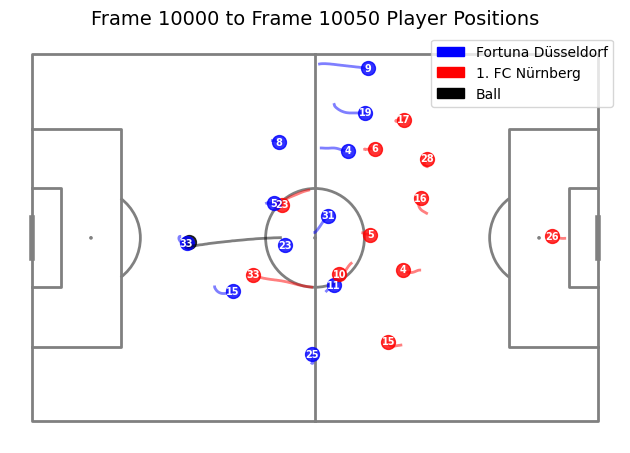

In [35]:
# Set up pitch using kloppy_dataset metadata (예시)
pitch = Pitch(
    pitch_type='secondspectrum', 
    pitch_length=kloppy_dataset.metadata.pitch_dimensions.pitch_length,
    pitch_width=kloppy_dataset.metadata.pitch_dimensions.pitch_width,
    pitch_color='white', 
    line_color='gray'
)

# 호출 예시 (home_team와 away_team 객체가 미리 정의되어 있다고 가정)
plot_window_frame_positions(total_df, period_id=1,start_frame_idx=10000, end_frame_idx=10050,
                             pitch=pitch, home_team_info=home_team, away_team_info=away_team)

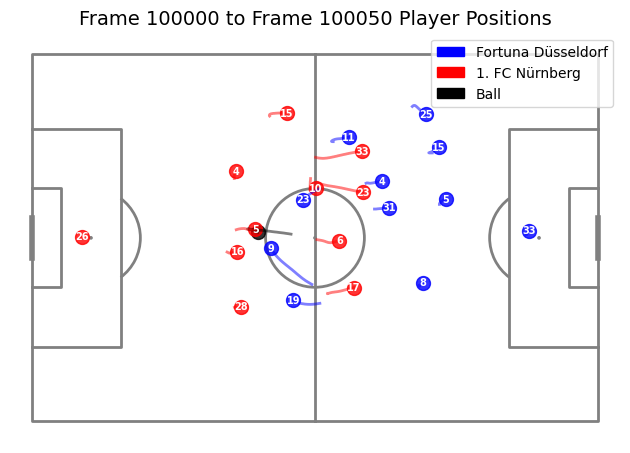

In [23]:
# Set up pitch using kloppy_dataset metadata (예시)
pitch = Pitch(
    pitch_type='secondspectrum', 
    pitch_length=kloppy_dataset.metadata.pitch_dimensions.pitch_length,
    pitch_width=kloppy_dataset.metadata.pitch_dimensions.pitch_width,
    pitch_color='white', 
    line_color='gray'
)

# 호출 예시 (home_team와 away_team 객체가 미리 정의되어 있다고 가정)
plot_window_frame_positions(total_df, period_id=2,start_frame_idx=100000, end_frame_idx=100050,
                             pitch=pitch, home_team_info=home_team, away_team_info=away_team)